# Introduction to Research Module

This tutorial introduces Research functionality of `batchflow`.

Research allows you to easily:
* experiment with models parameters combinations
* run multiple pipeline configurations (e.g. train and test workflow)
* add functions, customizing research process
* save and load results of experiments in a unified form

### Imports and Utilities

We start with some useful imports and constant definitions

In [1]:
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('..') #!!!

from matplotlib import pyplot as plt
%matplotlib inline

from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16, ResNet50
from batchflow.research import Research, Option, Domain, Results, PrintLogger, RP, RI, REU

In [2]:
%env CUDA_VISIBLE_DEVICES=0
BATCH_SIZE=64
ITERATIONS=100

env: CUDA_VISIBLE_DEVICES=0


In [3]:
def clear_previous_results(res_name):
    if os.path.exists(res_name):
        shutil.rmtree(res_name)

## Exploring model variability due to weight initialization

First we define a simple pipeline that loads MNIST dataset and trains VGG7 model on it. It also saves the loss on each iteration in a pipeline variable. Let's call it an `experiment`.

#### Loading Data and Creating Pipeline

We call a lazy version of pipeline's `run` method to define batch size to use. We pass `n_epochs=None`, because the duration of our experiment will be controlled by `Research` object.

In [4]:
mnist = MNIST()

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Creating Research

The simpliest thing we can do with Research is to run this experiment several times to see how loss dynamics changes from run to run due to diffetent weight initialization.

To do this we define a Research object, pass the number of experiment repetitions `n_reps=4` via `init_domain` and add the pipeline with `add_pipeline`, passing pipeline object as first parameter. The `variables` parameter gets a string or a list of strings that indicates which pipeline variables will be monitored by Research and written to research results on each iteration (note that we update `loss` variable with mode `'w'`). We also provide `name` that will be written to results, indicating their origin. Finally, `logging=True` adds additional logging of the pipeline execution to log stream.

In [5]:
research = (Research()
            .init_domain(n_reps=4)
            .add_pipeline(train_ppl, variables='loss', name='train_ppl', logging=True))

#### Running Research 

Each research is assigned with a name and writes its results to a folder with this name. The names must be unique, so if one attempts to run a research with a name that already exists, an error will be thrown. In the cell below we clear the results of previous research runs so as to allow multiple runs of a research. This is done solely for purposes of this tutorial and should not be done in real work.

In [6]:
res_name='vgg7_research'
clear_previous_results(res_name)

Now we run this Research with following parameters:
* `n_iters` - how many iterations will the experiment consist of. Each iteration here consists of processing a single batch
* `name` - research name, also acts as a name for corresponding save folder
* `bar` - toggles tqdm progress bar

In [7]:
research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research vgg7_research is starting...


Domain updated: 0: 100%|██████████| 400/400.0 [01:29<00:00,  4.47it/s]


#### Investigating Research Results

To see the experiments' results we call `load_result` method which returns pandas.Dataframe of 5 columns:
* name — name of pipeline that acts as a source for the variable
* loss — variable name passed earlier in `add_pipeline`
* iteration — experiment iteration number
* sample_index — unique id for each experiment
* repetition — experiment repetition number
* update - the number of domain updates before that experiment (idea will be described in the following tutorials)

In [8]:
results = research.load_results().df

In [9]:
results.sample(10)

,name,loss,iteration,sample_index,repetition,update
52,train_ppl,0.154408,52,1652346323,0,0
101,train_ppl,2.268986,1,2448141130,3,0
178,train_ppl,0.207504,78,2448141130,3,0
281,train_ppl,0.232918,81,1532163690,1,0
283,train_ppl,0.074660,83,1532163690,1,0
85,train_ppl,0.117818,85,1652346323,0,0
346,train_ppl,0.229933,46,1409388256,2,0
132,train_ppl,0.273315,32,2448141130,3,0
361,train_ppl,0.169061,61,1409388256,2,0
230,train_ppl,0.158013,30,1532163690,1,0


We can now draw a nice plot showing our loss dynamics on each experiment repetition.

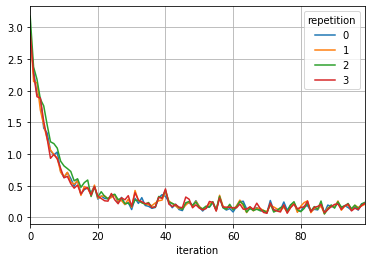

In [10]:
results.pivot(index='iteration', columns='repetition', values='loss').plot(grid=True)

## Adding more pipelines

#### Creating Test Pipeline

Usually we would like to run more than a single train pipeline.
Let's define a test pipeline to monitor loss of our model on test set while learning. 

We want to run the test pipeline on the whole test set from time to time during training. 

In order to get this, we specify lazy-run in test pipeline with `n_epochs=1` and then pass `run=True` to research's `add_pipeline`. These 2 parameter values tell Research to run the pipeline on the whole test set for 1 epoch.

To let the test pipeline use the model from train pipeline we'll pass it via `C('import_from')`, setting it's value when creating `Research`.

In [11]:
test_template = (Pipeline()
                 .init_variable('test_loss')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='loss', save_to=V('test_loss', mode='w'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1) #Note  n_epochs=1
                )

test_ppl = test_template << mnist.test

#### Creating Research with 2 Pipelines

`execute` parameter defines frequency of pipeline execution. One can tell research to execute a pipeline periodically and pass an `int`, or to execute it on specific iteration by passing zero-based iteration number in following format: `'#{it_no}'` or by simply passing `'last'`. `execute` can also be a list, for example `execute=["#0', '#123', 100, 'last']` means that a pipeline will be executed on first iteration, 124-th iteration, every 100-th iteration and the last one.

In order to import model from train to test pipeline, we pass `import_from='train_ppl'` parameter to `add_pipeline`, where `'train_ppl'` is the name of our train pipeline.

In [12]:
TEST_EXECUTE_FREQ = ['#1', '#5', '#50', '#99']

res_name = 'train_test_research'
clear_previous_results(res_name)

research = (Research()
            .init_domain(n_reps=4)
            .add_pipeline(train_ppl, variables='loss', name='train_ppl')
            .add_pipeline(test_ppl, variables='test_loss', name='test_ppl',
                        execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'), logging=True)) # Note run=True

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research train_test_research is starting...


Domain updated: 0: 100%|██████████| 400/400.0 [03:17<00:00,  2.03it/s]


Now our research results contain entries for `test_ppl`.

In [13]:
research.load_results(names='test_ppl').df.head()

,name,loss,test_loss,iteration,sample_index,repetition,update
0,test_ppl,NaN,2.265016,1,113473795,0,0
1,test_ppl,NaN,1.041643,5,113473795,0,0
2,test_ppl,NaN,0.193890,50,113473795,0,0
3,test_ppl,NaN,0.028072,99,113473795,0,0
4,test_ppl,NaN,4.547157,1,114193408,3,0


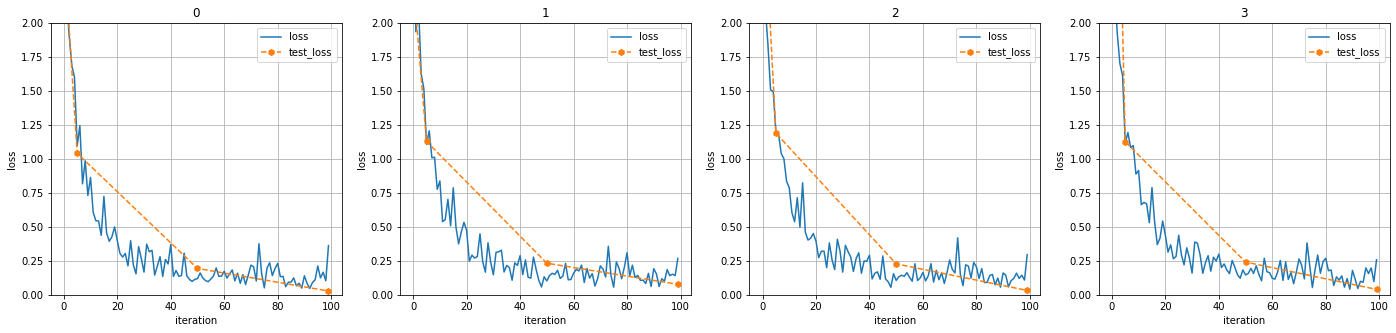

In [14]:
results = research.load_results().df
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for i, (rep, df) in enumerate(results.groupby('repetition')):
    losses = ['loss', 'test_loss']
    train = df[df['name'] == 'train_ppl'].set_index('iteration')[losses[0]]
    test = df[df['name'] == 'test_ppl'].set_index('iteration')[losses[1]]
    ax[i].plot(train)
    ax[i].plot(test, '--h')
    ax[i].set_title(rep)
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('loss')
    ax[i].grid(True)
    ax[i].legend(losses)
    ax[i].set_ylim(0, 2)

## Adding metrics

There is a special research method `get_metrics` for collecting metrics.

#### Defining Test Pipeline That Gathers Metrics

First we redefine test pipeline removing `'test_loss'` and adding variables to store predictions and metrics computed for these predictions via `gather_metrics`.

In [15]:
test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))

test_ppl = test_template << mnist.test

We pass test pipeline name to collect metrics from it (`pipeline='test_ppl'`), named expression storing collected metrics (`metrics_var='metrics'`) and string indicating which metric to calculate (`metrics_name='accuracy'`). We also can add `PrintLogger` as logger and all messages will be streamed into `stdout`.

In [16]:
res_name = 'get_metrics_research'
clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train_ppl')
            .add_pipeline(test_ppl, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'))
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=TEST_EXECUTE_FREQ)
            .init_domain(n_reps=4))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research get_metrics_research is starting...


Domain updated: 0: 100%|██████████| 400/400.0 [03:12<00:00,  2.08it/s]


`get_metrics` implicitly adds records with a name *\[pipeline_name\]_metrics*.

In [17]:
research.load_results(names='test_ppl_metrics').df.sample(5)

,name,loss,accuracy,iteration,sample_index,repetition,update
15,test_ppl_metrics,NaN,0.9375,99,628503454,2,0
12,test_ppl_metrics,NaN,0.0625,1,628503454,2,0
14,test_ppl_metrics,NaN,0.8750,50,628503454,2,0
5,test_ppl_metrics,NaN,0.3125,5,2352431942,3,0
11,test_ppl_metrics,NaN,0.8750,99,1318556819,1,0


Here you can see graphs of loss values and accuracy vs iteration number for each of four repetitions:

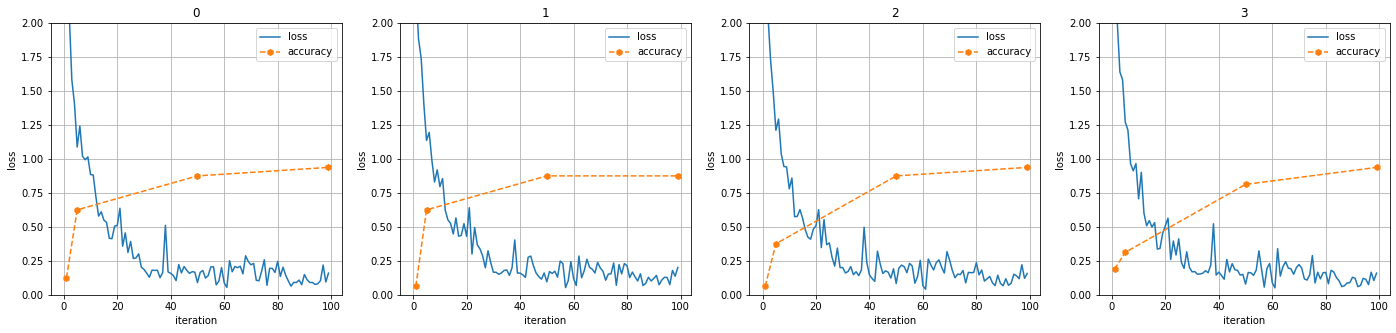

In [18]:
results = research.load_results().df
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for i, (rep, df) in enumerate(results.groupby('repetition')):
    values = ['loss', 'accuracy']
    train = df[df['name'] == 'train_ppl'].set_index('iteration')[values[0]]
    test = df[df['name'] == 'test_ppl_metrics'].set_index('iteration')[values[1]]
    ax[i].plot(train)
    ax[i].plot(test, '--h')
    ax[i].set_title(rep)
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('loss')
    ax[i].grid(True)
    ax[i].legend(values)
    ax[i].set_ylim(0, 2)

## Selecting between models: VGG7 vs VGG16 vs LogReg

We have learned to run multiple repetitions of a single experiment with Research. 

We can also run several experiments with different parameters in one research. Suppose we want to compare the performance of VGG7, VGG16 and ResNet18 on MNIST classification task.

#### Defining Domain

We define a domain of parameters as follows. 
We define an Option that consists of the parameter to vary and a list of values that we want to try in our research. Each parameter value defines a node in a parameter domain. We can add (`+`) domains to unite the nodes, multiply (`*`) them to get Cartesian product and also multiply domain options node-wise (`@`).

`domain.iterator()` is a generator that yields one node (that is, a single experiment specification) at a time. Printing a list of all nodes shows us all experiment modifications in a dict-like mode.

In [19]:
domain = Option('model', [VGG7, VGG16, ResNet50])

In [20]:
list(domain.iterator())

[ConfigAlias({'model': 'VGG7'}),
 ConfigAlias({'model': 'VGG16'}),
 ConfigAlias({'model': 'ResNet50'})]

#### Creating Pipelines With Variable Parameters

We should now update `model_config` so that it could read the values from `domain` defined above.

Passing config option named expressions `C()` as parameters values with names from our parameter domain we define layout, pool_strides and bias in the model config. Then, we define model type passing named expression to `init_model` method of the pipeline.

In [21]:
# For reference: previous train_template definition 
#     train_template = (Pipeline()
#                 .init_variable('loss', init_on_each_run=list)
#                 .init_model('dynamic', VGG7, 'conv', config=model_config) # Note model class defined explicitly
#                 .to_array()
#                 .train_model('conv', 
#                              images=B('images'), labels=B('labels'),
#                              fetches='loss', save_to=V('loss', mode='w'))
#     )

train_template = (Pipeline()
            .init_variable('loss', default=[])
            .init_model('dynamic', C('model'), 'conv', config=model_config) # Model class defined via named expression
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Adding Domain To Research

We define a new research as before but also add the domain of parameters with `init_domain` method. After that we run the research, and it takes much longer because we are now running 6 different experiments 2 times each beacuse we set `n_reps=2`. 

In [22]:
res_name = 'model_selection_research'
clear_previous_results(res_name)

research = (Research()
            .init_domain(domain, n_reps=2)
            .add_pipeline(train_ppl, variables='loss', name='train_ppl', logging=True)
            .add_pipeline(test_ppl, name='test_ppl',
                          execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'))
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=TEST_EXECUTE_FREQ)
)

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research model_selection_research is starting...


Domain updated: 0: 100%|██████████| 600/600.0 [06:17<00:00,  1.59it/s]


Research results now contain new column *model* with corresponding parameter values:

In [23]:
results = research.load_results().df
results.head()

,name,loss,accuracy,iteration,sample_index,model,repetition,update
0,train_ppl,3.422482,NaN,0,2006336840,VGG7,1,0
1,train_ppl,2.373052,NaN,1,2006336840,VGG7,1,0
2,train_ppl,1.938920,NaN,2,2006336840,VGG7,1,0
3,train_ppl,1.818365,NaN,3,2006336840,VGG7,1,0
4,train_ppl,1.718850,NaN,4,2006336840,VGG7,1,0


Here are plots of loss values and accuracy vs iteration number in both repetitions for each *model* option:

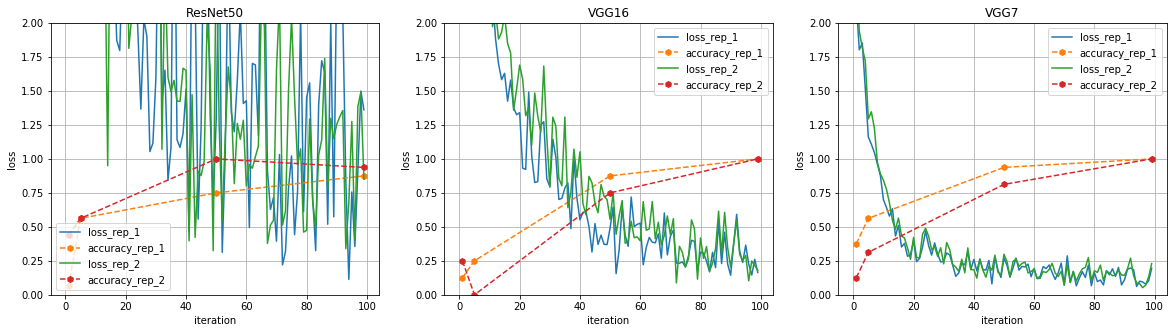

In [25]:
results = research.load_results().df
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, (model, df_model) in enumerate(results.groupby('model')):
    for j, (rep, df) in enumerate(df_model.groupby('repetition')):
        values = ['loss', 'accuracy']
        train = df[df['name'] == 'train_ppl'].set_index('iteration')[values[0]]
        test = df[df['name'] == 'test_ppl_metrics'].set_index('iteration')[values[1]]
        ax[i].plot(train)
        ax[i].plot(test, '--h')
        ax[i].set_title(model)
        ax[i].set_xlabel('iteration')
        ax[i].set_ylabel('loss')
        ax[i].grid(True)
        ax[i].legend(['loss_rep_1', 'accuracy_rep_1', 'loss_rep_2', 'accuracy_rep_2'])
        ax[i].set_ylim(0, 2)